# Задача:
1. Разработать модель(и) машинного обучения для прогнозирования ежедневного [[GMV]] (Gross Merchandise Value) и количества заказов на 7 дней вперед. Оценка качества прогнозов на основе MAPE.
  Что нужно сделать:
   * Исследовательский анализ данных (EDA).
   * Подготовка данных и генерация признаков (Feature Engineering).
   * Выбор и обучение модели.
   * Оценка качества прогнозов.
__________

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

| Название          | Описание                                               |
| ----------------- | ------------------------------------------------------ |
| `date`            | Дата отчета (формат ГГГГ-ММ-ДД)                        |
| `gmv`             | Фактический GMV за `date`                              |
| `orders`          | Общее количество заказов за `date`                     |
| `sessions`        | Общее количество сессий пользователей за `date`        |
| `marketing_spend` | Сумма затрат на маркетинг за `date`                    |
| `is_promo_active` | (0 или 1) Была ли активна крупная промо-акция в `date` |
| `day_of_week`     | День недели (1 - Понедельник, ..., 7 - Воскресенье)    |
| `day_of_year`     | Порядковый номер дня в году                            |
| `week_of_year`    | Порядковый номер недели в году                         |
| `month`           | Месяц                                                  |
| `year`            | Год                                                    |

In [2]:
df = pd.read_csv('daily_sales_metrics.csv')
df

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year
0,2022-01-01,506994,1081,34861,25148,0,5,1,52,1,2022
1,2022-01-02,445834,819,32858,23769,0,6,2,52,1,2022
2,2022-01-03,348150,736,23081,22108,0,0,3,1,1,2022
3,2022-01-04,359418,872,25166,21757,0,1,4,1,1,2022
4,2022-01-05,381439,871,31082,21420,0,2,5,1,1,2022
...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,891794,5410,171515,54332,0,3,361,52,12,2024
1091,2024-12-27,1011484,6330,219724,55346,0,4,362,52,12,2024
1092,2024-12-28,1064332,6767,229631,56839,0,5,363,52,12,2024
1093,2024-12-29,1150266,6829,223812,75393,1,6,364,52,12,2024


## 1. Исследовательский анализ данных (EDA)

### 1.1. Общее описание

In [3]:
df.dtypes

date               object
gmv                 int64
orders              int64
sessions            int64
marketing_spend     int64
is_promo_active     int64
day_of_week         int64
day_of_year         int64
week_of_year        int64
month               int64
year                int64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date             1095 non-null   object
 1   gmv              1095 non-null   int64 
 2   orders           1095 non-null   int64 
 3   sessions         1095 non-null   int64 
 4   marketing_spend  1095 non-null   int64 
 5   is_promo_active  1095 non-null   int64 
 6   day_of_week      1095 non-null   int64 
 7   day_of_year      1095 non-null   int64 
 8   week_of_year     1095 non-null   int64 
 9   month            1095 non-null   int64 
 10  year             1095 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 94.2+ KB


In [5]:
df.isnull().sum()

date               0
gmv                0
orders             0
sessions           0
marketing_spend    0
is_promo_active    0
day_of_week        0
day_of_year        0
week_of_year       0
month              0
year               0
dtype: int64

##### Пропусков нет

In [6]:
time_columns = list(df.columns[6:]) + ['date']
time_columns

['day_of_week', 'day_of_year', 'week_of_year', 'month', 'year', 'date']

In [7]:
print('Проверяем корректность временных данных')
for col in time_columns:
    print(col, ' : ', len(pd.unique(df[col])))

Проверяем корректность временных данных
day_of_week  :  7
day_of_year  :  365
week_of_year  :  52
month  :  12
year  :  3
date  :  1095


In [8]:
df[time_columns][(df['year']==2024) & (df['month']==2) & (df['date'].apply(lambda x: int(x[-2:])) > 20)]

,day_of_week,day_of_year,week_of_year,month,year,date
781,2,52,8,2,2024,2024-02-21
782,3,53,8,2,2024,2024-02-22
783,4,54,8,2,2024,2024-02-23
784,5,55,8,2,2024,2024-02-24
785,6,56,8,2,2024,2024-02-25
786,0,57,9,2,2024,2024-02-26
787,1,58,9,2,2024,2024-02-27
788,2,59,9,2,2024,2024-02-28
789,3,60,9,2,2024,2024-02-29


29 февраля в високосный год есть, при этом количество записей = 365*3 

In [9]:
print(df[time_columns][df['year']==2022][-3:])
print(df[time_columns][df['year']==2023][-3:])
print(df[time_columns][df['year']==2024][-3:])

     day_of_week  day_of_year  week_of_year  month  year        date
362            3          363            52     12  2022  2022-12-29
363            4          364            52     12  2022  2022-12-30
364            5          365            52     12  2022  2022-12-31
     day_of_week  day_of_year  week_of_year  month  year        date
727            4          363            52     12  2023  2023-12-29
728            5          364            52     12  2023  2023-12-30
729            6          365            52     12  2023  2023-12-31
      day_of_week  day_of_year  week_of_year  month  year        date
1092            5          363            52     12  2024  2024-12-28
1093            6          364            52     12  2024  2024-12-29
1094            0          365             1     12  2024  2024-12-30


В 2024 году отсутствует 31-ок декабря

##### Проверяем даты на корректность

In [10]:
df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce')
df['date_parsed'].isna().any()

False

Все даты корретны

### 1.2. Визуализации

In [11]:
df_to_visuilize = df[df.columns[1:6]]

#### Boxplots:

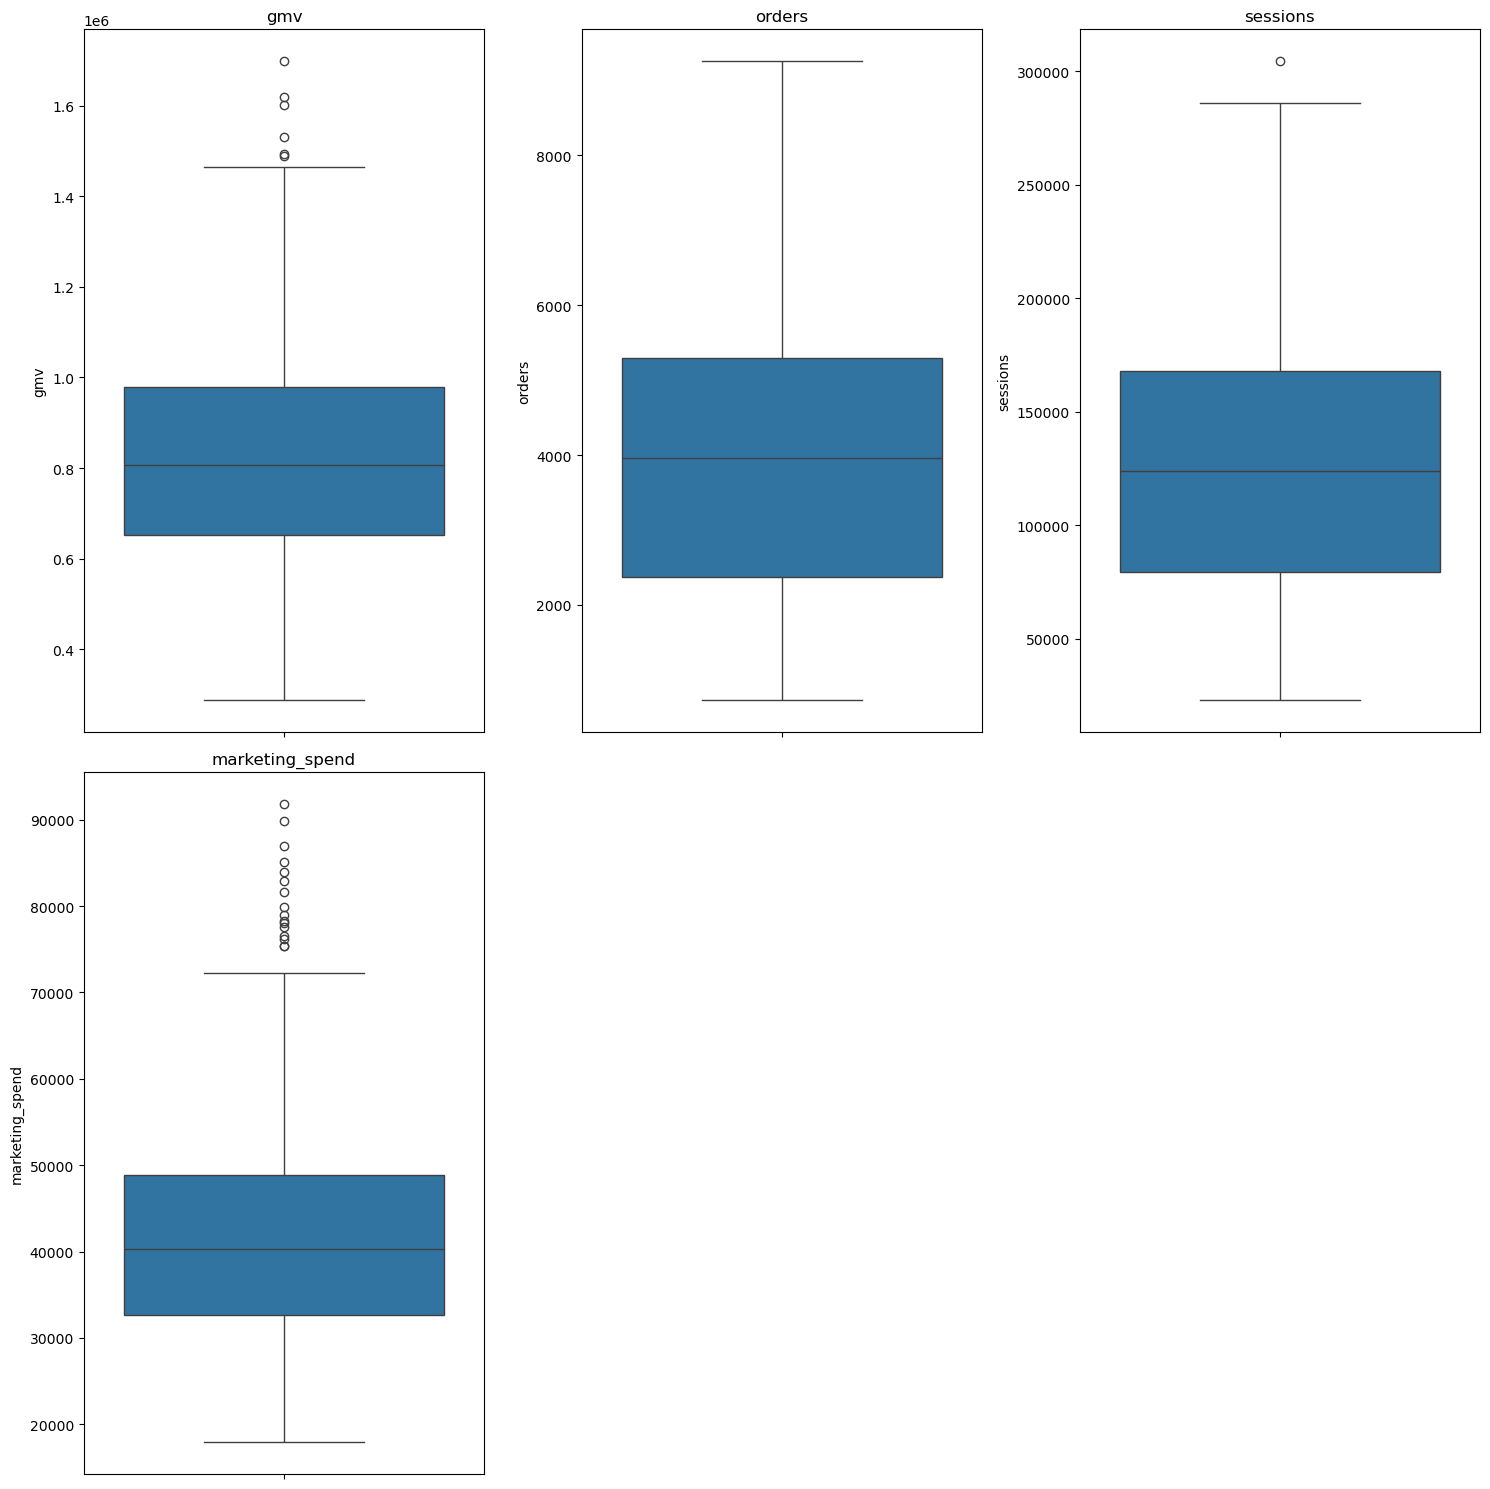

In [12]:

plt.figure(figsize=(15,15))

for i, col in enumerate(df_to_visuilize.columns[:-1]):
    plt.subplot(len(df_to_visuilize.columns[:-1])//3+1, 3, i+1)
    sns.boxplot(y=df_to_visuilize[col])
    plt.title(col)

plt.tight_layout()
plt.show()


#### Выбросы

In [13]:
outliers = {}
for i, col in enumerate(df_to_visuilize.columns[:-1]):
    Q1 = df[col].quantile(0.25)  
    Q3 = df[col].quantile(0.75)  
    IQR = Q3 - Q1  
    outliers[col] = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]  
    print(f'Количество выбросов в столбце {col}: {len(outliers[col])}')

Количество выбросов в столбце gmv: 6
Количество выбросов в столбце orders: 0
Количество выбросов в столбце sessions: 1
Количество выбросов в столбце marketing_spend: 16


#### Гистограммы:

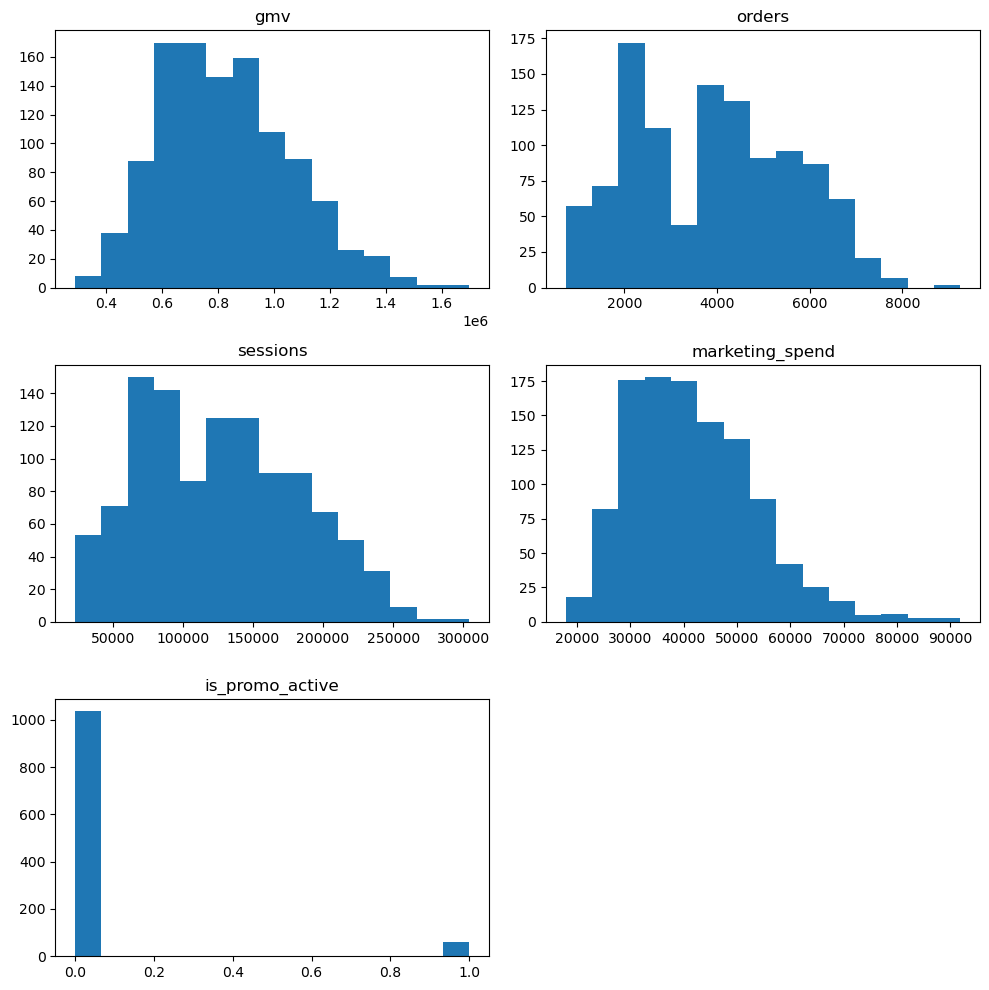

is_promo_active
0    1036
1      59
Name: count, dtype: int64


In [14]:
plt.figure(figsize=(10,10))

buf=[]
for i, col in enumerate(df_to_visuilize.columns):
    plt.subplot(len(df_to_visuilize.columns)//2+1, 2, i+1)
    plt.hist(df_to_visuilize[col], bins=15)
    plt.title(col)
    if len(pd.unique(df_to_visuilize[col])) <11:
        buf.append(df_to_visuilize[col].value_counts())

plt.tight_layout()
plt.show()
for b in buf:
    print(b)

#### Матрица корреляций:

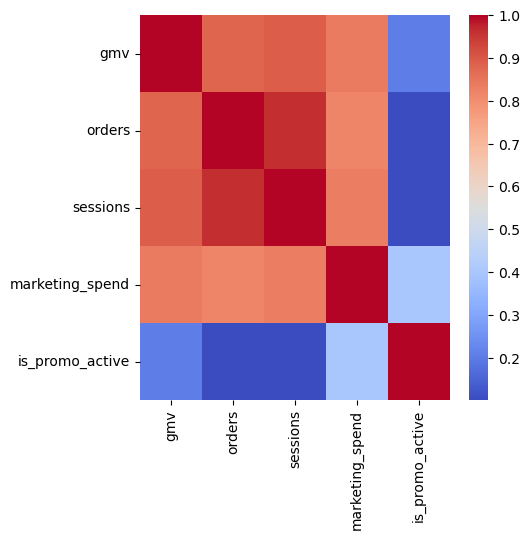

In [15]:
plt.figure(figsize=(5, 5))
sns.heatmap(df_to_visuilize.corr(), annot =False, cmap ="coolwarm")
plt.show()

#### Временная зависимость

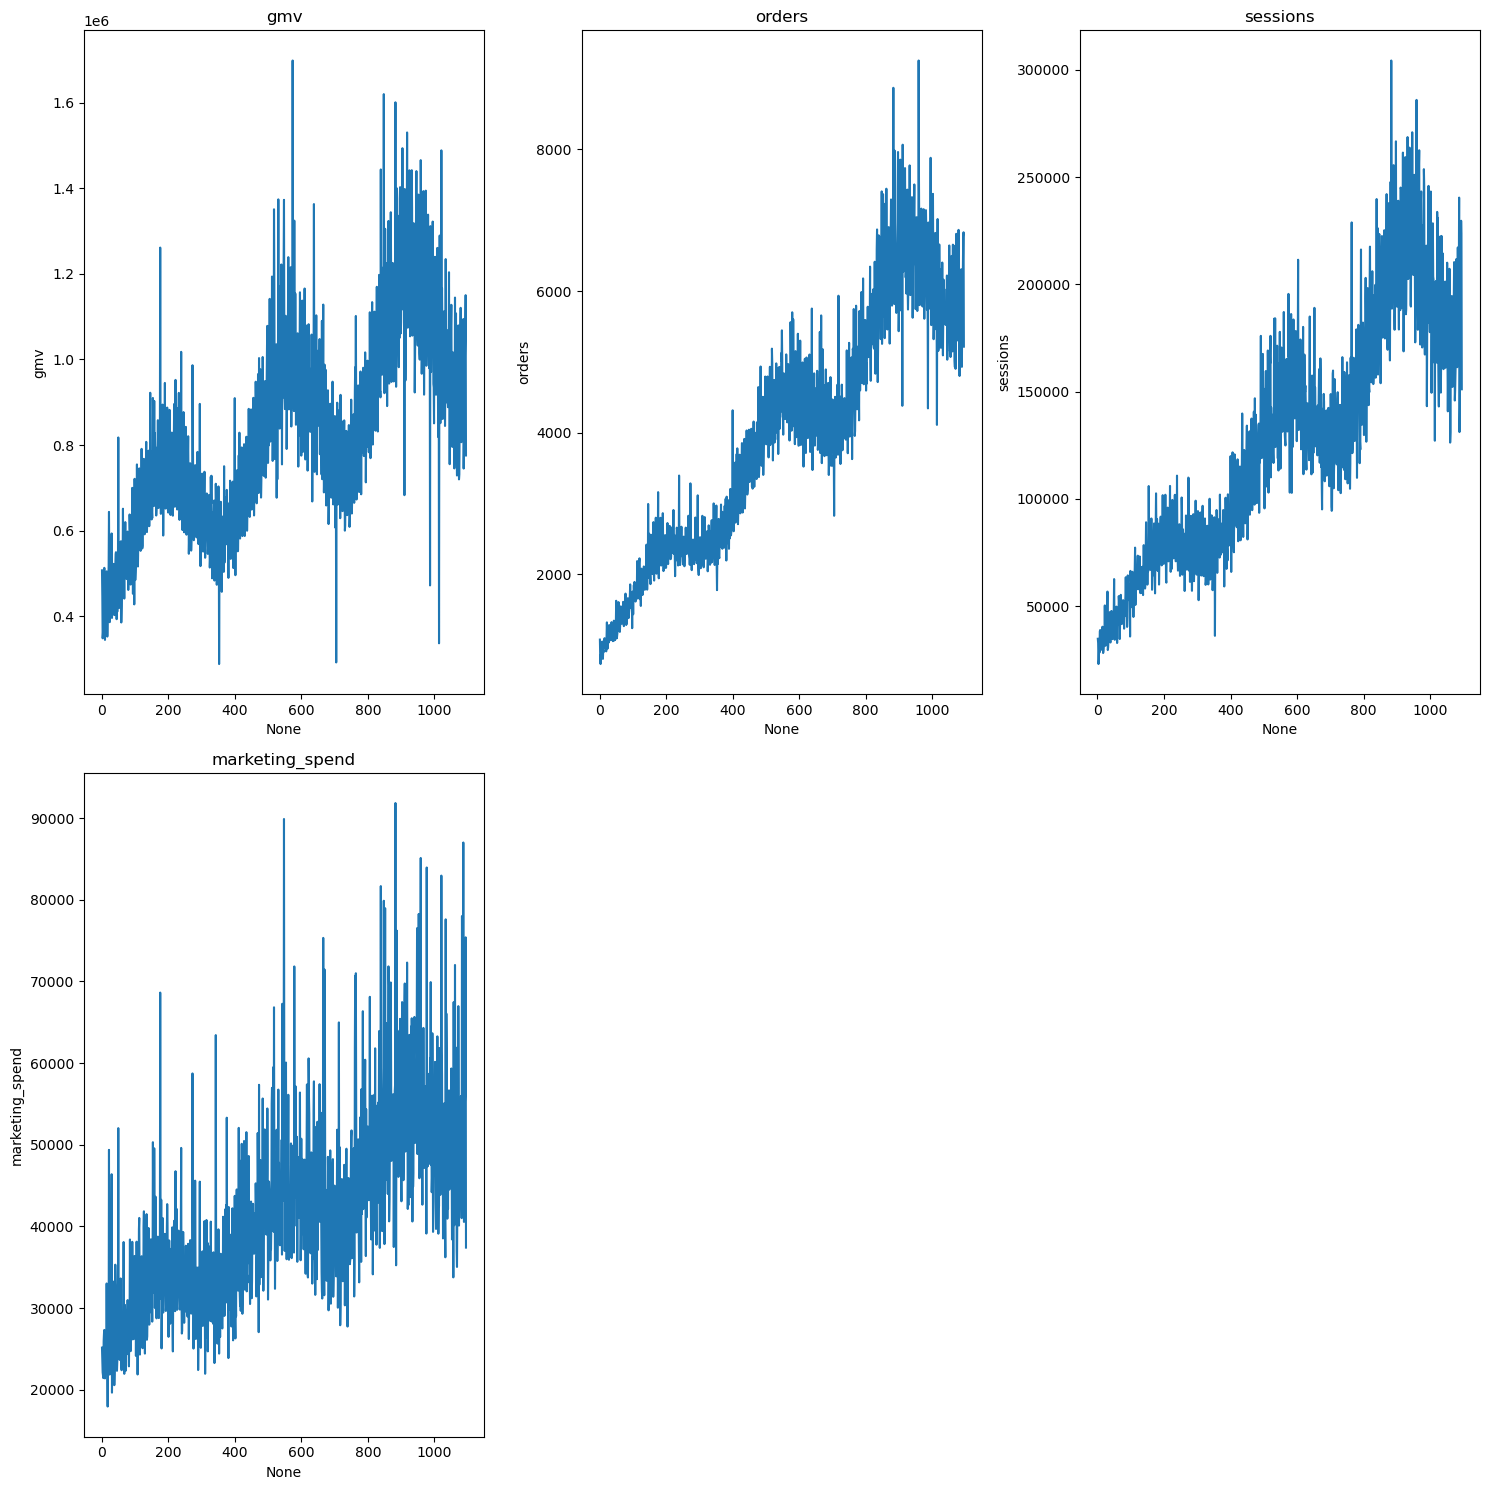

In [16]:

plt.figure(figsize=(15,15))

for i, col in enumerate(df_to_visuilize.columns[:-1]):
    plt.subplot(len(df_to_visuilize.columns[:-1])//3+1, 3, i+1)
    sns.lineplot(y=df_to_visuilize[col], x=df.index+1)
    plt.title(col)

plt.tight_layout()
plt.show()

Видим похожие циклы каждый год

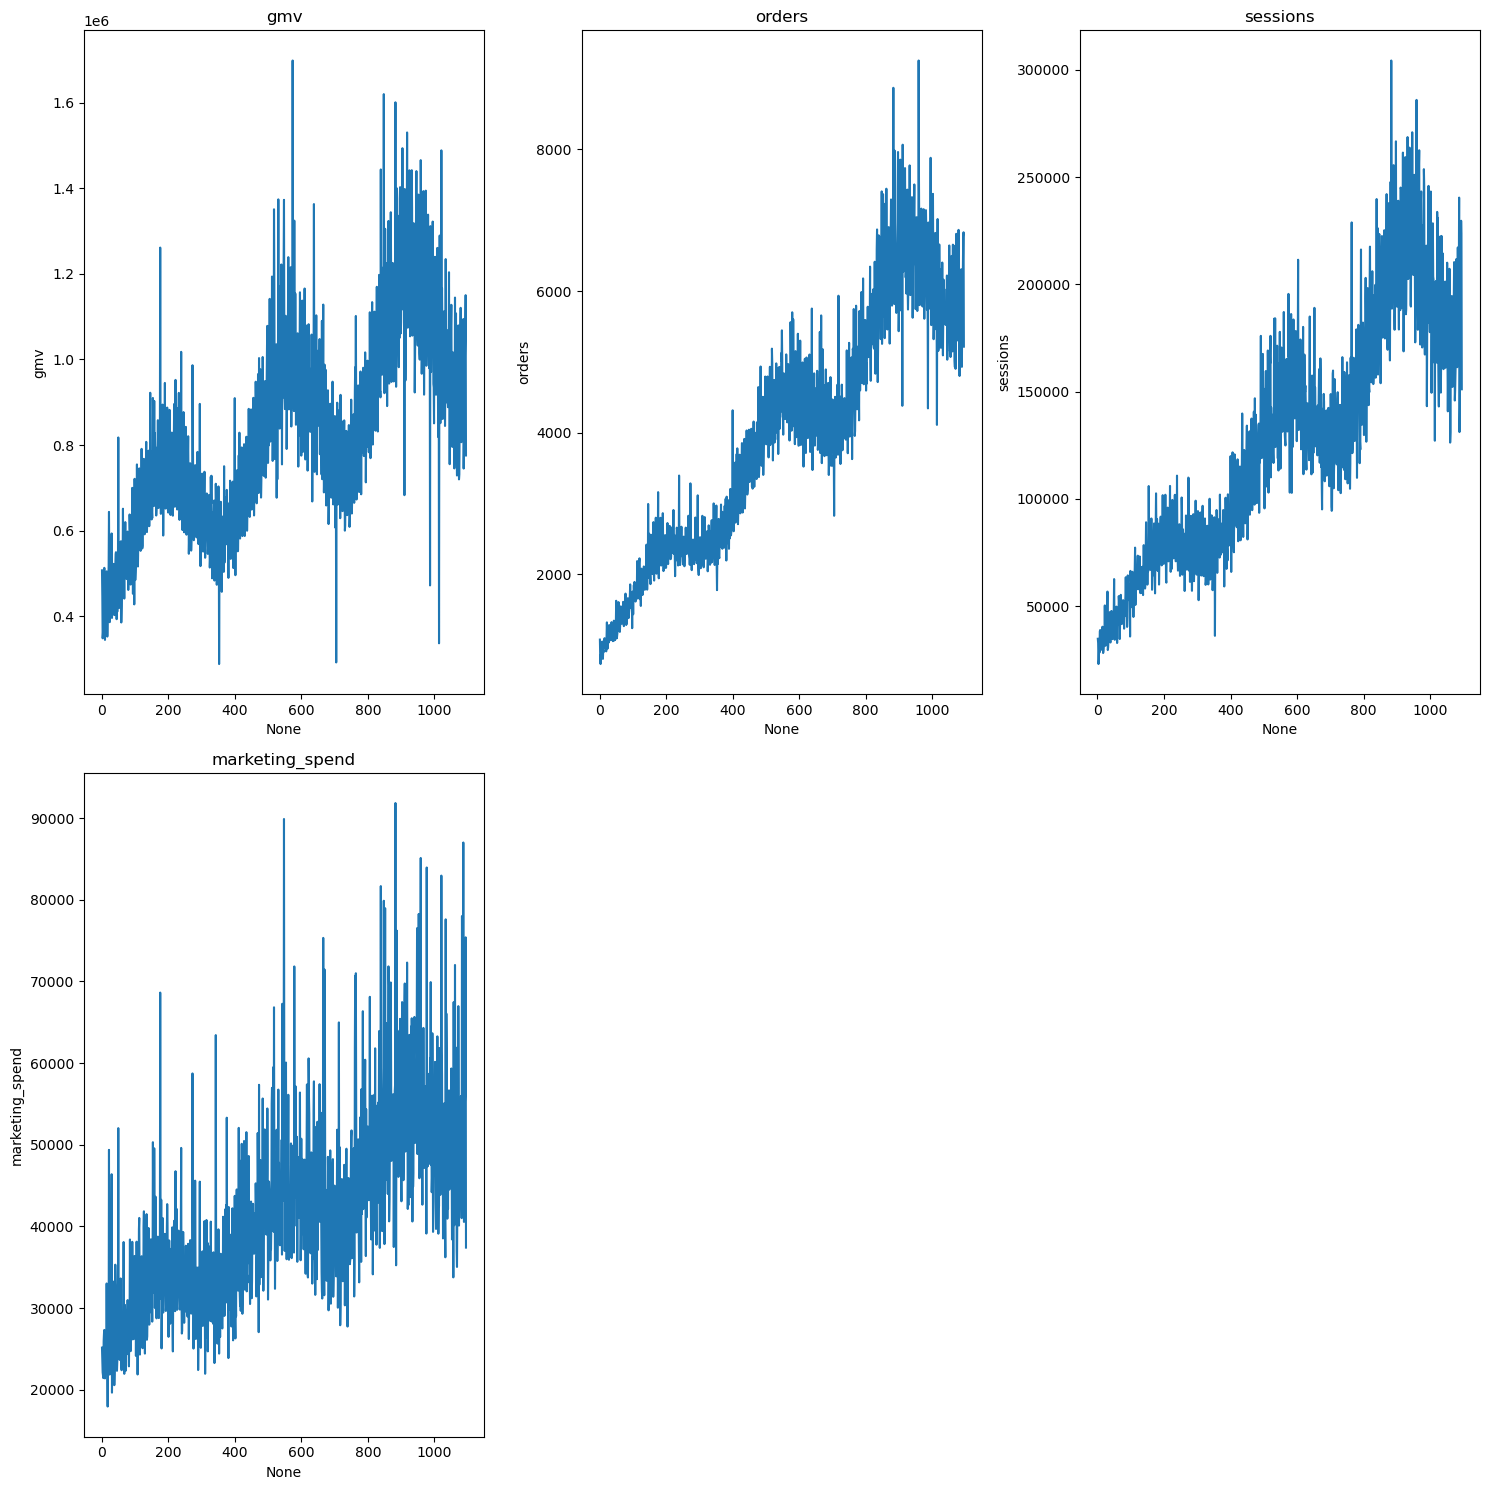

In [17]:

plt.figure(figsize=(15,15))

for i, col in enumerate(df_to_visuilize.columns[:-1]):
    plt.subplot(len(df_to_visuilize.columns[:-1])//3+1, 3, i+1)
    sns.lineplot(y=df_to_visuilize[col], x=df.index+1)
    plt.title(col)

plt.tight_layout()
plt.show()

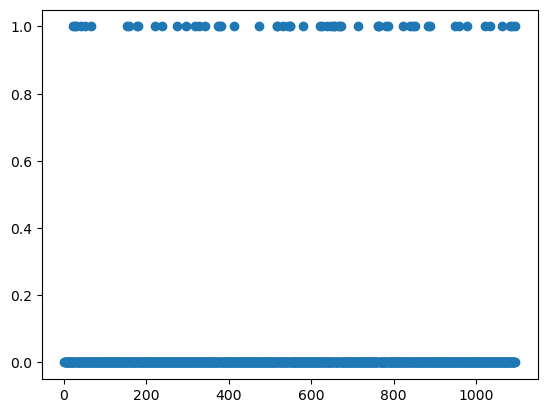

In [39]:
plt.scatter(y=df['is_promo_active'], x=df.index+1)
plt.show()

**Видна сезонность**

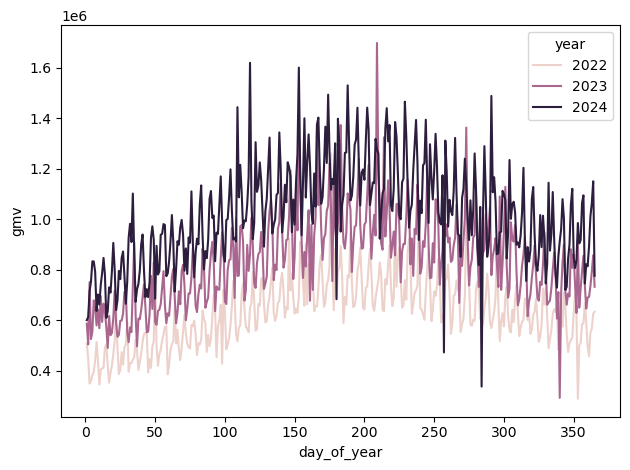

In [18]:
sns.lineplot(data=df, x="day_of_year", y="gmv", hue="year", errorbar=('ci', 95), err_style='band')
plt.tight_layout()
plt.show()

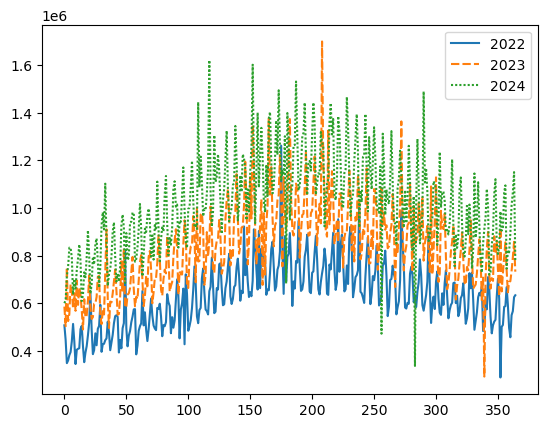

In [19]:
def group_data_by_year(df, column):
    grouped_data = {}
    for year, year_data in df.groupby(by='year'):
        grouped_data[year]=year_data[column].reset_index(drop=True)
    
    return pd.DataFrame(data=grouped_data)

sns.lineplot(data = group_data_by_year(df, 'gmv'), errorbar="sd")
plt.show()

## 2. Подготовка данных и генерация признаков (Feature Engineering).

### 2.1. Feature engineering

- **holiday_proximity** "близость праздника" в зависимости от близости праздника, в который принято дарить подарки в течении следующих десяти дней значение этого будет иметь значения от 0.1 до 1, в остальные дни значение этого признака будет равно 0.

Даты таких праздников:

01.01 - новый год

23.02 - день защитника отечества

08.03 - международные женский день

01.09 - 1-ое сентрября не совсем вписывается в остальные, но тем не менее к этой дате люди часто покупают вещи

In [20]:
gift_holidays = ['01-01', '02-23', '03-08', '01-09']

df['holiday_proximity']=df['date'].apply(lambda x: 1 if x[-5:] in gift_holidays else 0)
df[['holiday_proximity', 'date']][df['holiday_proximity']==1]

,holiday_proximity,date
0,1,2022-01-01
8,1,2022-01-09
53,1,2022-02-23
66,1,2022-03-08
365,1,2023-01-01
373,1,2023-01-09
418,1,2023-02-23
431,1,2023-03-08
730,1,2024-01-01
738,1,2024-01-09


In [31]:
import pandas as pd
from datetime import datetime, timedelta

# Даты праздников (формат 'MM-DD')
gift_holidays = ['01-01', '02-23', '03-08', '09-01']

def calculate_holiday_proximity(date_str, holiday_dates=gift_holidays, days_before=9):
    """
    Возвращает значение от 0.1 до 1, если до праздника осталось <=10 дней, иначе 0.
    
    Параметры:
    - date_str: Дата в формате строки (например, '2023-02-20')
    - holiday_dates: Список праздников в формате 'MM-DD'
    - days_before: За сколько дней до праздника начинается "близость" (по умолчанию 10)
    
    Возвращает:
    - float: Значение от 0.1 до 1 (чем ближе к празднику, тем выше)
    """
    try:
        current_date = datetime.strptime(date_str, '%Y-%m-%d').date()
    except:
        return 0.0  # если дата некорректна
    
    max_proximity = 0.0
    
    for holiday in holiday_dates:
        # Получаем дату праздника в текущем году
        holiday_date = datetime.strptime(f"{current_date.year}-{holiday}", '%Y-%m-%d').date()
        
        # Если праздник уже прошел в этом году, проверяем следующий год
        if holiday_date < current_date:
            holiday_date = datetime.strptime(f"{current_date.year + 1}-{holiday}", '%Y-%m-%d').date()
        
        # Вычисляем разницу в днях
        delta = (holiday_date - current_date).days
        
        # Если до праздника <=10 дней, вычисляем "близость" (1 - в сам праздник, 0.1 - за 10 дней)
        if 0 <= delta <= days_before:
            proximity = 1.0 - (delta / days_before) * 0.9  # линейное убывание от 1 до 0.1
            if proximity > max_proximity:
                max_proximity = proximity
    
    return round(max_proximity, 2) if max_proximity > 0 else 0.0


df_test = df.copy(deep=True)
df_test['holiday_proximity'] = df_test['date'].apply(calculate_holiday_proximity)
df_test

,date,gmv,orders,sessions,marketing_spend,is_promo_active,day_of_week,day_of_year,week_of_year,month,year,date_parsed,holiday_proximity
0,2022-01-01,506994,1081,34861,25148,0,5,1,52,1,2022,2022-01-01,1.0
1,2022-01-02,445834,819,32858,23769,0,6,2,52,1,2022,2022-01-02,0.0
2,2022-01-03,348150,736,23081,22108,0,0,3,1,1,2022,2022-01-03,0.0
3,2022-01-04,359418,872,25166,21757,0,1,4,1,1,2022,2022-01-04,0.0
4,2022-01-05,381439,871,31082,21420,0,2,5,1,1,2022,2022-01-05,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,2024-12-26,891794,5410,171515,54332,0,3,361,52,12,2024,2024-12-26,0.4
1091,2024-12-27,1011484,6330,219724,55346,0,4,362,52,12,2024,2024-12-27,0.5
1092,2024-12-28,1064332,6767,229631,56839,0,5,363,52,12,2024,2024-12-28,0.6
1093,2024-12-29,1150266,6829,223812,75393,1,6,364,52,12,2024,2024-12-29,0.7


In [32]:
df_test[['date','holiday_proximity']][(df_test['month']==12) & (df_test['year']==2022)].tail(15)

,date,holiday_proximity
350,2022-12-17,0.0
351,2022-12-18,0.0
352,2022-12-19,0.0
353,2022-12-20,0.0
354,2022-12-21,0.0
355,2022-12-22,0.0
356,2022-12-23,0.1
357,2022-12-24,0.2
358,2022-12-25,0.3
359,2022-12-26,0.4


- Сдвиг gmv **gmv_lag_7** на 8 дней (так как предсказываем на 7 дней)

In [45]:
df["gmv_lag_7"] = df["gmv"].shift(7)

In [48]:
df[["gmv_lag_7", "gmv", 'date']].head(20)

,gmv_lag_7,gmv,date
0,NaN,506994,2022-01-01
1,NaN,445834,2022-01-02
2,NaN,348150,2022-01-03
3,NaN,359418,2022-01-04
4,NaN,381439,2022-01-05
5,NaN,394592,2022-01-06
6,NaN,440207,2022-01-07
7,506994.0,512868,2022-01-08
8,445834.0,440238,2022-01-09
9,348150.0,344412,2022-01-10


In [ ]:
numeric_columns = df.columns[1:5]
numeric_columns

Index(['gmv', 'orders', 'sessions', 'marketing_spend'], dtype='object')

#### Обработка выбросов

In [22]:
outliers['gmv'][['gmv', 'date']]

,gmv,date
573,1698764,2023-07-28
847,1620170,2024-04-27
882,1601092,2024-06-01
903,1493832,2024-06-22
917,1530583,2024-07-06
1020,1488764,2024-10-17


In [23]:
outliers['sessions'][['sessions', 'date']]

,sessions,date
882,304300,2024-06-01


In [24]:
outliers['marketing_spend'][['marketing_spend', 'date']]

,marketing_spend,date
547,89884,2023-07-02
665,75323,2023-10-28
838,81666,2024-04-18
847,79871,2024-04-27
851,78960,2024-05-01
882,91841,2024-06-01
886,76210,2024-06-05
947,76513,2024-08-05
952,78254,2024-08-10
958,85110,2024-08-16
